In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
sns.set()

In [2]:
df = pd.read_csv('CC GENERAL.csv')

In [3]:
#Steps:
# DATA PREPROCESSING (NULLS, DUPES, OUTLIERS, DROP NON-USEFUL COLUMNS)
# SCATTER OF 2 VARIABLES
# PCA
# KMEANS ELBOW
# KMEANS CLUSTERING OF ALL VARIABLES

In [4]:
#DATA PREPROCESSING
df.info()
#Looks like CREDIT_LIMIT and MINIMUM_PAYMENTS have missing values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8950 entries, 0 to 8949
Data columns (total 18 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   CUST_ID                           8950 non-null   object 
 1   BALANCE                           8950 non-null   float64
 2   BALANCE_FREQUENCY                 8950 non-null   float64
 3   PURCHASES                         8950 non-null   float64
 4   ONEOFF_PURCHASES                  8950 non-null   float64
 5   INSTALLMENTS_PURCHASES            8950 non-null   float64
 6   CASH_ADVANCE                      8950 non-null   float64
 7   PURCHASES_FREQUENCY               8950 non-null   float64
 8   ONEOFF_PURCHASES_FREQUENCY        8950 non-null   float64
 9   PURCHASES_INSTALLMENTS_FREQUENCY  8950 non-null   float64
 10  CASH_ADVANCE_FREQUENCY            8950 non-null   float64
 11  CASH_ADVANCE_TRX                  8950 non-null   int64  
 12  PURCHA

In [5]:
#Imputing the missing values with the medians of the values; Using medians because there are outliers
df.loc[df['CREDIT_LIMIT'].isna(), 'CREDIT_LIMIT'] = df['CREDIT_LIMIT'].median()
df.loc[df['MINIMUM_PAYMENTS'].isna(), 'MINIMUM_PAYMENTS'] = df['MINIMUM_PAYMENTS'].median()

In [6]:
#Checking for duplicates
df.duplicated().any()
#No duplicates

False

In [7]:
#Dropping cust_id columns because it does not help with clustering
df.drop('CUST_ID', axis=1, inplace=True)

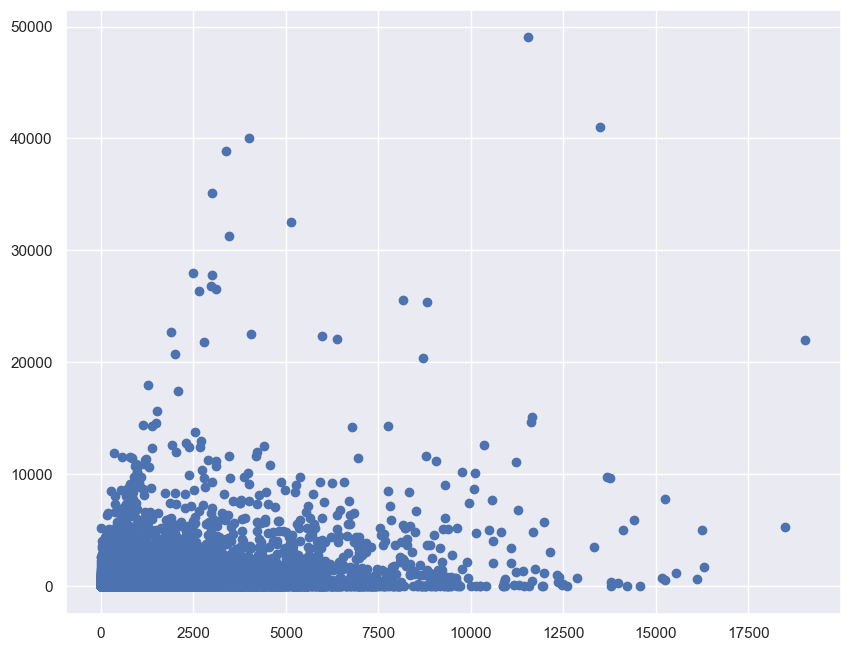

In [8]:
x = df['BALANCE']
y = df['PURCHASES']
plt.figure(figsize=(10,8), dpi=100)
plt.scatter(x=x, y=y)

In [9]:
#Constructing a scatterplot of 2 variables
scatter_kmeans = KMeans(2)

In [10]:
scatter_kmeans.fit(pd.concat((df['PURCHASES'], df['PAYMENTS']), axis=1))

KMeans(n_clusters=2)

In [11]:
df = pd.concat([df, pd.DataFrame({'CLUSTER_LABEL_1' : scatter_kmeans.labels_})], axis=1)

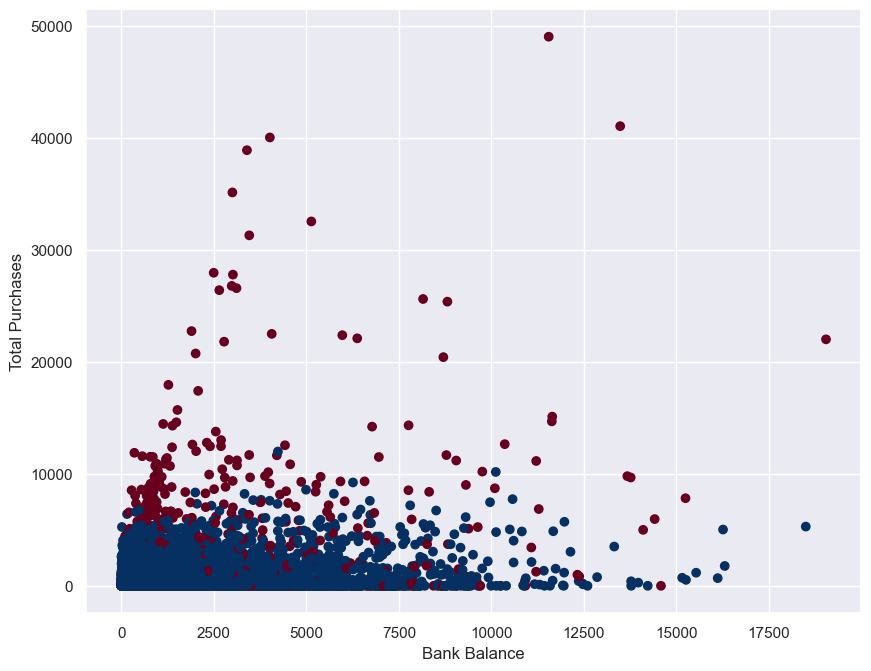

In [12]:
x = df['BALANCE']
y = df['PURCHASES']
plt.figure(figsize=(10,8), dpi=100)
plt.xlabel(f'Bank Balance')
plt.ylabel(f'Total Purchases')
plt.scatter(x=x, y=y, c=df['CLUSTER_LABEL_1'], cmap='RdBu')

In [13]:
#Removing cluster column
df = df.drop('CLUSTER_LABEL_1', axis=1)

#Scaling data for PCA
sc = StandardScaler()
df_scaled = sc.fit_transform(df)

In [14]:
#Using PCA to reduce dimensionality of the columns to 2 (for scatter plotting)
pca = PCA(2)
pca_values = pca.fit_transform(df_scaled)

In [15]:
#Using the elbow method to find the optimal number of kmeans
inertia = []
for x in range(1, 8):
    kmean = KMeans(x)
    kmean.fit(pca_values)
    inertia.append(kmean.inertia_)

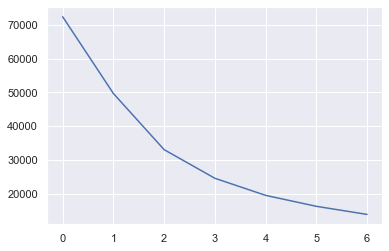

In [16]:
#Plotting the inertia chart (elbow method)
plt.plot(inertia)
#It looks like 3 - 4 is the optimal number of clusters; I'm going to use 4

In [17]:
x = pca_values[:, 0]
y = pca_values[:, 1]

pca_df = pd.DataFrame({
    'x' : x,
    'y' : y
})

In [18]:
#Using the 4 clusters as I mentioned above
pca_kmeans = KMeans(4)
pca_kmeans.fit(pca_df)

KMeans(n_clusters=4)

In [19]:
#Setting up the df for plotting clusters
pca_df_final = pd.concat([pca_df, pd.DataFrame({'Cluster' : pca_kmeans.labels_})], axis=1)

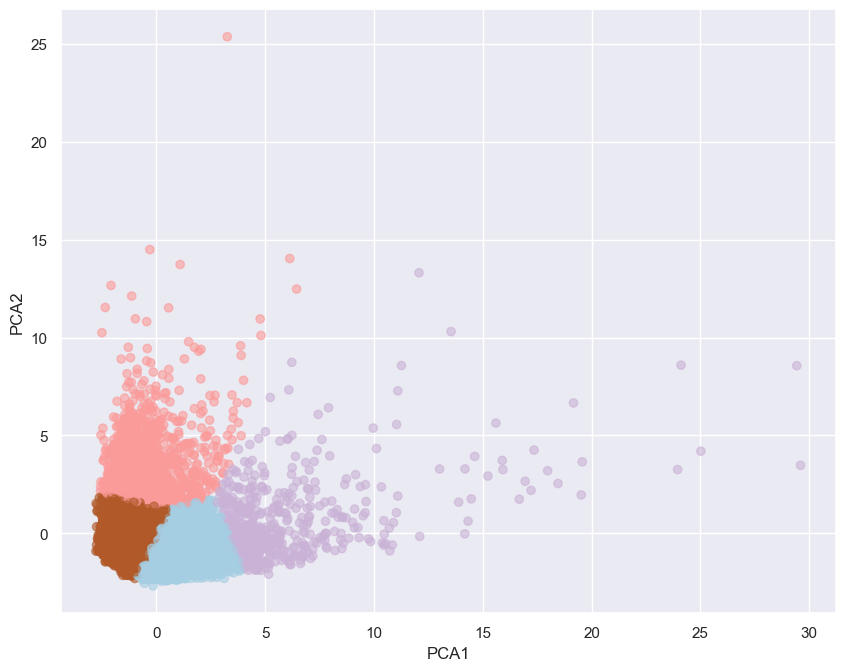

In [37]:
plt.figure(figsize=(10,8), dpi=100)
plt.xlabel(f'PCA1')
plt.ylabel(f'PCA2')
plt.scatter(x=pca_df_final['x'], y=pca_df_final['y'], c=pca_df_final['Cluster'], cmap='Paired', alpha=0.6)

In [22]:
output_df = pd.concat([df, pca_df_final['Cluster']], axis=1)

In [39]:
pca_df_final.groupby('Cluster').agg('mean')

,x,y
Cluster,,
0,0.909456,-1.167139
1,-0.530158,3.418970
2,5.987864,0.672892
3,-1.364996,-0.197570


In [25]:
output_df.groupby('Cluster').agg('mean')

,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
Cluster,,,,,,,,,,,,,,,,,
0,825.574264,0.920343,1236.056041,621.930195,614.331116,147.881796,0.862479,0.302070,0.674870,0.030751,0.571777,21.311490,4254.273164,1329.464791,575.999115,0.282672,11.662603
1,4505.482729,0.963545,462.285405,300.034964,162.349615,4396.927323,0.266299,0.129755,0.166255,0.470416,13.762630,6.712911,7446.435081,3539.962037,2075.286744,0.034964,11.440257
2,3404.463516,0.988473,6878.287842,4498.958931,2380.517030,772.147388,0.954623,0.725605,0.809703,0.084800,2.358416,82.760396,9520.693069,6704.524571,1879.778621,0.286873,11.960396
3,1009.892650,0.799390,222.920125,157.172234,66.077090,613.426981,0.190116,0.074718,0.110096,0.122342,2.258872,2.952515,3107.455536,855.130438,545.032344,0.066333,11.363033
